In [25]:
import sys; sys.path.append("../..") # use local neural_maxwell package

import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from pdb import set_trace as breakpoint
from time import time

from neural_maxwell.datasets.fdfd import Simulation1D
from neural_maxwell.datasets.generators import PermittivityGenerators1D 
from neural_maxwell.datasets.datasets import PermittivityDataset
from neural_maxwell.models.maxwell_1d import MaxwellSolver1D
from neural_maxwell.constants import *
from neural_maxwell.utils import pbar
from neural_maxwell.plotting import plot_model_outputs_1d

## Training

In [29]:
# Hyperparameters
num_epochs = 300
# learning_rate = 5e-6
batch_size = 512

# Create a model   
channels = [64] * 7
kernels = [7] * 7
model = MaxwellSolver1D(channels=channels, kernels=kernels, drop_p=0.0).to(device)

# Create data loaders
train_data = PermittivityDataset(PermittivityGenerators1D.random_number_random_layers, N=5e5, infinite_mode=False)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = PermittivityDataset(PermittivityGenerators1D.random_number_random_layers, N=1e3, infinite_mode=False)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

# Loss and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)#, weight_decay=0.001) 

In [30]:
model.densenet

Sequential(
  (0): Linear(in_features=1408, out_features=1408, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.0)
  (3): Linear(in_features=1408, out_features=1408, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.0)
)

In [31]:
# Train the model
model.train()
total_step = len(train_loader)
epoch_iterator = pbar(range(num_epochs))
params = []

for epoch in epoch_iterator:
    
    SHOW_ITERATION_PROGRESS = True
    if SHOW_ITERATION_PROGRESS:
        train_loader = pbar(train_loader)
        
    for i, epsilons in enumerate(train_loader):
        
        epsilons = epsilons.float().to(device)
        
        # Forward pass
        if False:
            # Supervised case
            outputs = model(epsilons, supervised=True)
        else:
            # Unsupervised case
            outputs = model(epsilons)

        loss = criterion(outputs, torch.zeros_like(outputs))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if SHOW_ITERATION_PROGRESS:
            train_loader.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)
    epoch_iterator.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)

KeyboardInterrupt: 

In [32]:
# Save the model checkpoint
torch.save(model.state_dict(), '../models/checkpoints/model1d_mar25.ckpt')

In [33]:
# Compute loss on test set

model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
test_losses = []

with torch.no_grad():
    start = time()
    for epsilons in pbar(test_loader):
        epsilons = epsilons.float().to(device)
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        test_losses.append(loss.item())

print(f"Mean loss: {np.mean(np.array(test_losses))}, time: {time()-start}")

Mean loss: 0.0010818979980249423, time: 3.1757760047912598


Error: 0.19445249438285828
Loss: 0.0005908089224249125
Sim time: 0.00699 | Network time: 0.00370 | Ratio: 0.52878


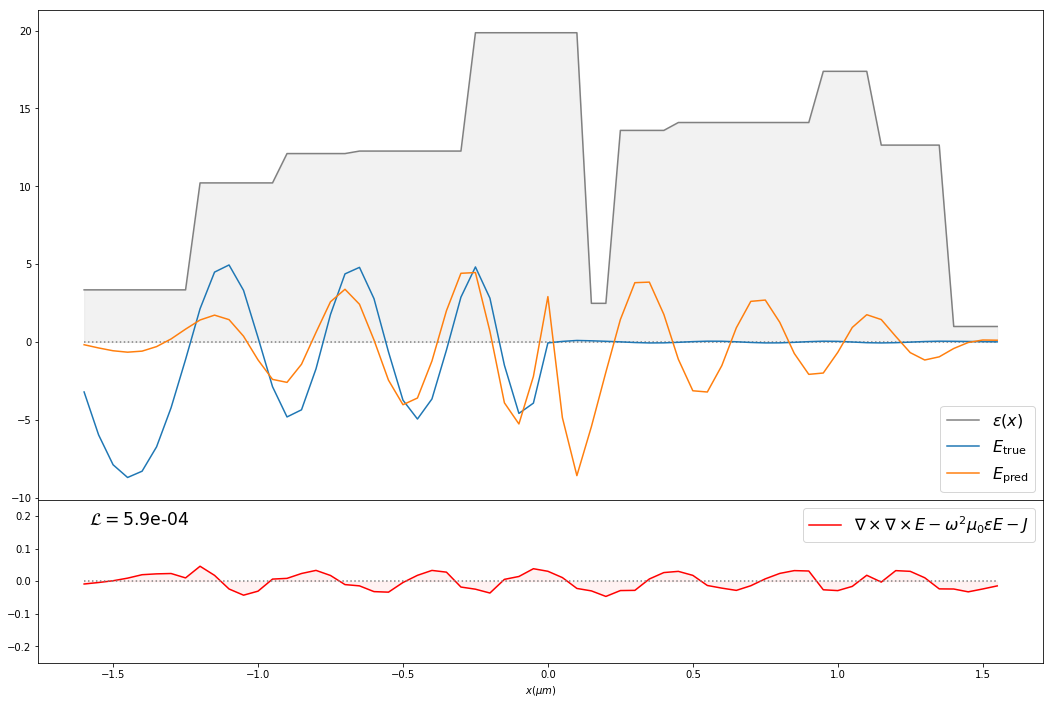

In [40]:
model.eval()
epsilons = PermittivityGenerators1D.random_number_random_layers()
plot_model_outputs_1d(model, epsilons, rescale=True)